## 1. Exploratory Data Analysis

We are going to be working with the **Wine** dataset. This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features for you to work with. 

In [32]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [33]:
print(X.shape)
print(y.shape)

(178, 4)
(178,)


### 1.1. Visualising the data



In [34]:
# define plotting function
import seaborn as sns
def myplotGrid(X,y):
    sns.set()
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    
    data = pd.concat((X, y), axis=1)
    data.columns= ['x1','x2','x3','x4','Y']
    
    sns.pairplot(data, hue='Y', diag_kind="kde")


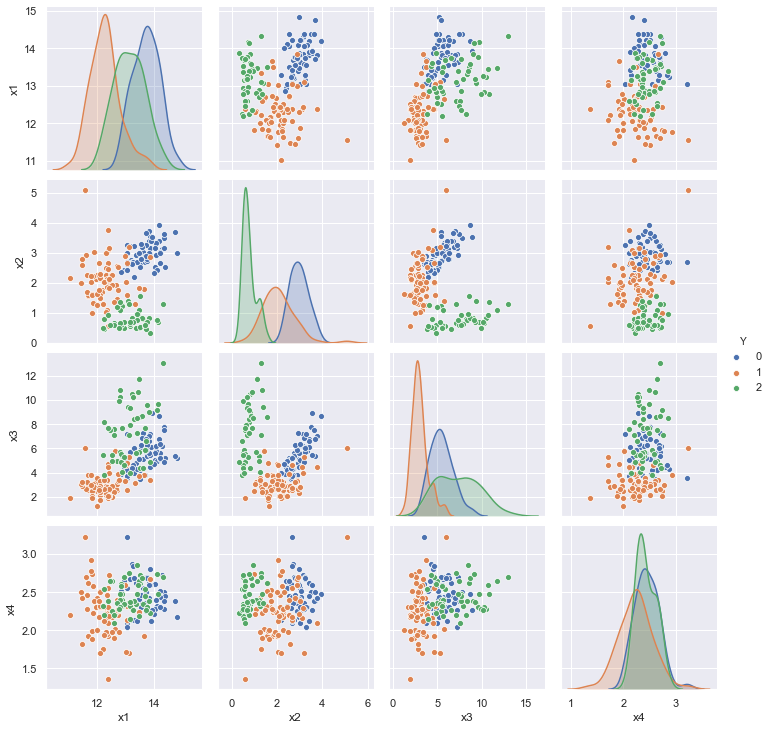

In [35]:
# run the plotting function
myplotGrid(X,y)

### 1.2. Exploratory Data Analysis under noise



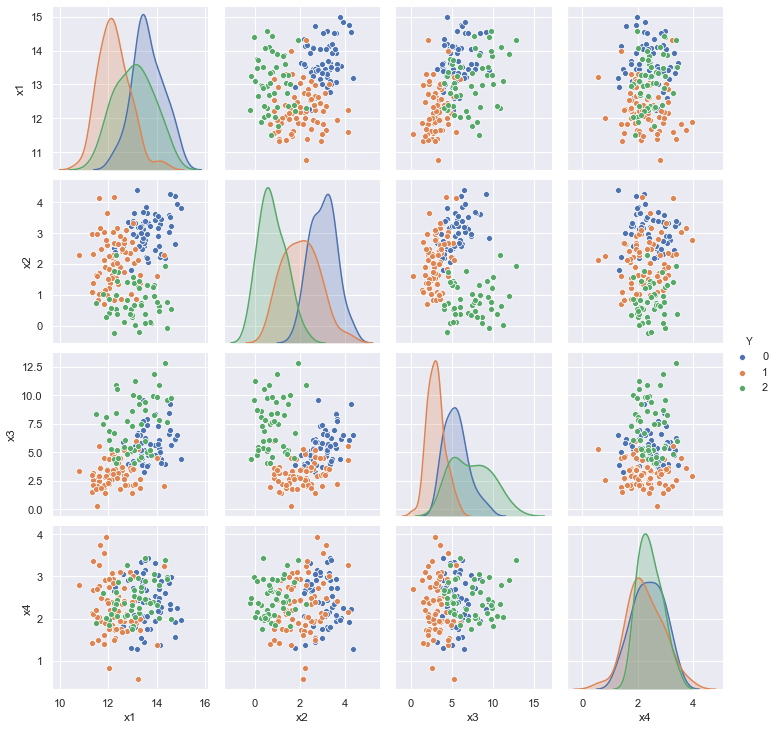

In [36]:
# noise code 
mySeed = 12345 
np.random.seed(mySeed) 
XN=X+np.random.normal(0,0.5,X.shape)

myplotGrid(XN,y)

## 2. Implementing kNN 


In [37]:
# helper code

def manhattan_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += abs(row1[i] - row2[i])
    return distance
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
        
    return sqrt(distance)

def get_neighbors(train, test_row, num_neighbors,distance_metric = 'euclidean'):
    distances = list()
    for train_row in train:
        if distance_metric=='euclidean':
            dist = euclidean_distance(test_row, train_row[:-1])
        else:
            dist = manhattan_distance(test_row, train_row[:-1])
        
        distances.append((train_row, dist))

    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

In [38]:
# mykNN code
from math import sqrt
def mykNN(X,y,X_,num_neighbors,distance_metric='euclidean'):
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    
    data = pd.concat((X, y), axis=1)
    data = np.array(data)
    predictions = list()
    for i in X_:
        neighbors = get_neighbors(data, i, num_neighbors,distance_metric)
        output_values = [row[-1] for row in neighbors]
        prediction = max(set(output_values), key=output_values.count)
        predictions.append(prediction)
    return predictions

predictions = mykNN(X,y, X, 5)

## 3. Classifier evaluation



In [39]:
# confusion matrix, accuracy, precision, recall, etc. 
def accuracy(y_true,y_pred):
    return ((y_true==y_pred)==True).sum()*100/len(y_true)


def compute_confusion_matrix(true, pred):

  K = len(np.unique(true)) # Number of classes 
  result = np.zeros((K, K))

  for i in range(len(true)):
    result[true[i],
           int(pred[i])] += 1
  result = result.astype(int)
  return result

def precision(label, confusion_matrix):
    tp =0
    fp = 0
    for i in range(0,len(confusion_matrix)):
        tp += confusion_matrix[i,i]
    for i in range(0,len(confusion_matrix)):
        for j in range(i+1,len(confusion_matrix)):
            fp+=confusion_matrix[i,j]
            
    #print(tp,fp)
    return 100*tp/(tp+fp)

    
def recall(label, confusion_matrix):
    tp =0
    fn = 0
    for i in range(0,len(confusion_matrix)):
        tp += confusion_matrix[i,i]
    for i in range(0,len(confusion_matrix)):
        for j in range(0,i):
            fn+=confusion_matrix[i,j]
    #print(tp, fn)        
    return 100*tp/(tp+fn)

In [40]:
# test evaluation code
predictions = mykNN(X,y, X, 5)

cm = compute_confusion_matrix(y, predictions)
print("Accuracy: ",accuracy(y,predictions))
print("Confusion Matrix: ",cm)

print("Precision: ",precision(y,cm))
print("Recall: ",recall(y,cm))


Accuracy:  96.06741573033707
Confusion Matrix:  [[59  0  0]
 [ 4 65  2]
 [ 0  1 47]]
Precision:  98.84393063583815
Recall:  97.1590909090909



## 4. Nested Cross-validation using your implementation of KNN 


In [41]:
# parameters for testing code
nFolds = 4
np.random.seed(mySeed)

# Creates an array of random permutation of indices between 0 and the length of the X data.
# The indices are then split up into (folds) folds
indices = np.random.permutation(np.arange(0,len(X),1))
indices = np.array_split(indices, nFolds)


In [42]:
# myNestedCrossVal code
from random import seed
from random import randrange


def cross_validation_split(dataset, folds=3):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split
def myNestedCrossVal(X,y,n_folds=5,
                     range_of_neigbors=list(range(1,11)),
                     dist_metric=['euclidean','manhattan'],
                     mySeed= 12345):
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    
    data = pd.concat((X, y), axis=1)
    data = np.array(data)
    accuracies = list()
    splits = cross_validation_split(data,n_folds)
    params = list()
    c = 1
    universal_cm =[]
    universal_best = 0
    for split in splits:
        best = 0
        print("******************************")
        print('No. of Fold: ',c)
        c+=1
        split = np.asarray(split)
        X = np.array(data)
        for i in split:
            index = (np.where(np.all(X==i,axis=1)))[0]
            X = np.delete(X,index,axis = 0)
        
        X_ = split
        y_ = split[:,-1].astype(int)
        y = X[:,-1]
        X = X[:,:-1]
        for dist in dist_metric:
            for k in range_of_neigbors:
                print('********')
                print('Distance Metrics: ', dist, 'Number of Neighbors: ',k)
                predictions = mykNN(X,y, split, k,distance_metric=dist_metric)
                
                acc = accuracy(split[:,-1],predictions)
                print("Accuracy: ",acc)
                if (acc>best):
                    best = acc
                    params = (dist,k)
        
        predictions = mykNN(X,y, split, params[1],distance_metric=params[0])
        acc = accuracy(split[:,-1],predictions)
        accuracies.append(acc)
        print('Best set of params: ', params)
        cm = compute_confusion_matrix(y_, predictions)
        if (acc>universal_best):
            universal_cm = cm
            universal_best = best

        print('Confusion Matrix: \n',cm)
    return accuracies, universal_cm

In [43]:
# evaluate clean data code
clean_accs, _ = myNestedCrossVal(X, y,mySeed=mySeed,dist_metric=['euclidean','manhattan'])

******************************
No. of Fold:  1
********
Distance Metrics:  euclidean Number of Neighbors:  1
Accuracy:  91.42857142857143
********
Distance Metrics:  euclidean Number of Neighbors:  2
Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  3
Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  4
Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  5
Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  6
Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  7
Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  8
Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  9
Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  10
Accuracy:  88.57142857142857
********
Distance Metrics:  manhattan Numb

Accuracy:  97.14285714285714
********
Distance Metrics:  euclidean Number of Neighbors:  10
Accuracy:  94.28571428571429
********
Distance Metrics:  manhattan Number of Neighbors:  1
Accuracy:  97.14285714285714
********
Distance Metrics:  manhattan Number of Neighbors:  2
Accuracy:  97.14285714285714
********
Distance Metrics:  manhattan Number of Neighbors:  3
Accuracy:  97.14285714285714
********
Distance Metrics:  manhattan Number of Neighbors:  4
Accuracy:  97.14285714285714
********
Distance Metrics:  manhattan Number of Neighbors:  5
Accuracy:  97.14285714285714
********
Distance Metrics:  manhattan Number of Neighbors:  6
Accuracy:  97.14285714285714
********
Distance Metrics:  manhattan Number of Neighbors:  7
Accuracy:  97.14285714285714
********
Distance Metrics:  manhattan Number of Neighbors:  8
Accuracy:  97.14285714285714
********
Distance Metrics:  manhattan Number of Neighbors:  9
Accuracy:  97.14285714285714
********
Distance Metrics:  manhattan Number of Neighbors:  

In [44]:
# evaluate noisy  data code
noisy_accs, _ = myNestedCrossVal(XN, y,mySeed=mySeed,dist_metric=['euclidean','manhattan'])

******************************
No. of Fold:  1
********
Distance Metrics:  euclidean Number of Neighbors:  1
Accuracy:  85.71428571428571
********
Distance Metrics:  euclidean Number of Neighbors:  2
Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  3
Accuracy:  91.42857142857143
********
Distance Metrics:  euclidean Number of Neighbors:  4
Accuracy:  91.42857142857143
********
Distance Metrics:  euclidean Number of Neighbors:  5
Accuracy:  91.42857142857143
********
Distance Metrics:  euclidean Number of Neighbors:  6
Accuracy:  91.42857142857143
********
Distance Metrics:  euclidean Number of Neighbors:  7
Accuracy:  91.42857142857143
********
Distance Metrics:  euclidean Number of Neighbors:  8
Accuracy:  91.42857142857143
********
Distance Metrics:  euclidean Number of Neighbors:  9
Accuracy:  91.42857142857143
********
Distance Metrics:  euclidean Number of Neighbors:  10
Accuracy:  94.28571428571429
********
Distance Metrics:  manhattan Numb

Accuracy:  94.28571428571429
********
Distance Metrics:  manhattan Number of Neighbors:  8
Accuracy:  94.28571428571429
********
Distance Metrics:  manhattan Number of Neighbors:  9
Accuracy:  91.42857142857143
********
Distance Metrics:  manhattan Number of Neighbors:  10
Accuracy:  91.42857142857143
Best set of params:  ('euclidean', 6)
Confusion Matrix: 
 [[14  0  0]
 [ 2  9  0]
 [ 0  0 10]]


## 5. Confusion matrix summary


In [45]:
_, clean_cm = myNestedCrossVal(X, y,mySeed=mySeed,dist_metric=['euclidean','manhattan'])
_, noisy_cm = myNestedCrossVal(XN, y,mySeed=mySeed,dist_metric=['euclidean','manhattan'])

******************************
No. of Fold:  1
********
Distance Metrics:  euclidean Number of Neighbors:  1
Accuracy:  97.14285714285714
********
Distance Metrics:  euclidean Number of Neighbors:  2
Accuracy:  97.14285714285714
********
Distance Metrics:  euclidean Number of Neighbors:  3
Accuracy:  97.14285714285714
********
Distance Metrics:  euclidean Number of Neighbors:  4
Accuracy:  97.14285714285714
********
Distance Metrics:  euclidean Number of Neighbors:  5
Accuracy:  100.0
********
Distance Metrics:  euclidean Number of Neighbors:  6
Accuracy:  97.14285714285714
********
Distance Metrics:  euclidean Number of Neighbors:  7
Accuracy:  100.0
********
Distance Metrics:  euclidean Number of Neighbors:  8
Accuracy:  100.0
********
Distance Metrics:  euclidean Number of Neighbors:  9
Accuracy:  100.0
********
Distance Metrics:  euclidean Number of Neighbors:  10
Accuracy:  94.28571428571429
********
Distance Metrics:  manhattan Number of Neighbors:  1
Accuracy:  97.14285714285714

Accuracy:  82.85714285714286
********
Distance Metrics:  manhattan Number of Neighbors:  1
Accuracy:  88.57142857142857
********
Distance Metrics:  manhattan Number of Neighbors:  2
Accuracy:  85.71428571428571
********
Distance Metrics:  manhattan Number of Neighbors:  3
Accuracy:  85.71428571428571
********
Distance Metrics:  manhattan Number of Neighbors:  4
Accuracy:  82.85714285714286
********
Distance Metrics:  manhattan Number of Neighbors:  5
Accuracy:  82.85714285714286
********
Distance Metrics:  manhattan Number of Neighbors:  6
Accuracy:  82.85714285714286
********
Distance Metrics:  manhattan Number of Neighbors:  7
Accuracy:  82.85714285714286
********
Distance Metrics:  manhattan Number of Neighbors:  8
Accuracy:  82.85714285714286
********
Distance Metrics:  manhattan Number of Neighbors:  9
Accuracy:  82.85714285714286
********
Distance Metrics:  manhattan Number of Neighbors:  10
Accuracy:  82.85714285714286
Best set of params:  ('euclidean', 1)
Confusion Matrix: 
 [[

Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  3
Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  4
Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  5
Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  6
Accuracy:  88.57142857142857
********
Distance Metrics:  euclidean Number of Neighbors:  7
Accuracy:  85.71428571428571
********
Distance Metrics:  euclidean Number of Neighbors:  8
Accuracy:  85.71428571428571
********
Distance Metrics:  euclidean Number of Neighbors:  9
Accuracy:  85.71428571428571
********
Distance Metrics:  euclidean Number of Neighbors:  10
Accuracy:  85.71428571428571
********
Distance Metrics:  manhattan Number of Neighbors:  1
Accuracy:  88.57142857142857
********
Distance Metrics:  manhattan Number of Neighbors:  2
Accuracy:  88.57142857142857
********
Distance Metrics:  manhattan Number of Neighbors:  

In [46]:
print('CLEAN')
# clean data summary results
print(clean_cm)


print('NOISY')
# clean data summary results
print(noisy_cm)


CLEAN
[[15  0  0]
 [ 0 12  0]
 [ 0  1  7]]
NOISY
[[ 9  0  0]
 [ 0 13  0]
 [ 0  0 13]]
